### Do feature selection during doc classification
#### Feature selection according to:
- Probability of being spurious
- Human label as gold standard
- Random order as baseline

#### Evaluation in doc classification:
- Majority group 
> (bad_pos, pos), (bad_neg, neg) <br>
> (sample same number of docs for each word) <br>

- Minority group
> (bad_pos, neg), (bad_neg, pos) <br>

- Test group (majority + minority)
- Random group

In [7]:
import copy, io, time
from io import BytesIO
from itertools import combinations, cycle, product
from IPython.display import display
import math
import matplotlib.pyplot as plt
%matplotlib inline

import pickle, tarfile, random, re, requests
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', -1)

from tqdm.notebook import tqdm

import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_recall_fscore_support

import warnings
warnings.filterwarnings("ignore")

In [8]:
from data_structure import Dataset, SentenceEdit

In [9]:
def load_data_with_term_prob():
    """
    load data that each term has a predicted probability of being genuine / (1-spurious);
    ds_data:
        - dataframe of [X, y, ..., ites, term_df]
        - ites is dataframe of matched sentence pairs: ['term','sentence_id','treat_obj','control_obj','similarity','difference','ite']
        - term_df is dataframe of feature representations (calculated from ites) for each term (e.g., ite features, coef, predicted_prob);
    
    use_prob: OOB (domain transfer), 5cv (same domain)
    Load data from file:
        ds.BAD_POS
        ds.BAD_NEG
        ds.term_df.predicted_prob
    """
    random.seed(42)
    
    path = '/data/zwang/2020_S/EMNLP/V_7_rerun/' #V_6_shortSents

    ds_kindle, ds_imdb, ds_toxic_tw, ds_toxic = pickle.load(open(path+'datasets_with_term_prob.pickle','rb'))
#     ds_kindle_s2t, ds_imdb_s2t, ds_toxic_tw_s2t, ds_toxic_s2t = pickle.load(open(path+'datasets_src2tar_OOB_prob.pickle','rb'))

    return ds_kindle, ds_imdb, ds_toxic_tw, ds_toxic

In [4]:
ds_kindle, ds_imdb, ds_toxic_tw, ds_toxic = load_data_with_term_prob()

In [161]:
ds_toxic_tw.moniker#term_df.columns#term_df[['term','cv_prob']].head()

'toxic_tw'

In [10]:
def iter_options():
    # iterate over combinations of options.
    for use_probs in product(['oracle','feature_selection','domain_transfer','random'], [True, False]):
            if(not (use_probs=='random' and do_weight)):
                yield (use_probs, do_weight)
                        
def line_styles():
    """
    different line markers
    """
    markers = ['<', '+', '*',  'v', 's', 'D', 'P', 'o', '.','<', '>', '1', '+', 'X',
               '^', 's', '*', 'D', 'P', '.', 'v', '<', '>', '1',  'X']
    lines = ['-', '--', '-.', ':'] * 6
    
    return cycle(['%s%s' % (m, l) for l, m in zip(lines, markers)])


In [11]:
def sample_from_training_data(ds_data, train_idx, test_idx, test_majority_idx, test_minority_idx, axs):
    """
    In training set, sample n_majority = n_minority;
    Balance the effect of majority and minority groups in training set;
    Fit classifier on balanced training set and check performance on evaluation groups.
    """
    bad_term_stats, majority_idx, minority_idx = get_term_stats(ds_data,train_idx)
    
    smp_majority_idx = list(random.sample(majority_idx, len(minority_idx)))
    smp_train_idx = list(set(train_idx) - (set(majority_idx) - set(smp_majority_idx)))
    print("Train data distribution after sample majority group:",Counter(ds_data.y[smp_train_idx]))
    
    clf = LogisticRegression(class_weight='auto', solver='lbfgs', max_iter=1000)
    clf.fit(ds_data.X[smp_train_idx], ds_data.y[smp_train_idx])
    
    group_score = {}
    for group, gp_idx in zip(['majority','minority','random'],[test_majority_idx, test_minority_idx, test_idx]):
        if(ds_data.moniker in ['Toxic comment','Toxic tweet']):
            group_score[group] = accuracy_score(ds_data.y[gp_idx],clf.predict(ds_data.X[gp_idx]))
        else:
            group_score[group] = roc_auc_score(ds_data.y[gp_idx],clf.predict_proba(ds_data.X[gp_idx]))
   
    # Horizontal line indicating the performance when training data is balanced 
    for i,group in enumerate(['majority','minority','random']):
        axs[i].axhline(group_score[group], alpha=0.8, linestyle='--')
    

In [29]:
def get_term_stats(df, data_idx):
    """
    Collect information about how often each word appears in majority and minority category.
    df: dataframe of each dataset
    data_idx: docs to sample from;
    
    For bad terms, sample the evaluation groups:
        Majority groups: (bad_pos, pos), (bad_neg, neg) 
        Minority groups: (bad_pos, neg), (bad_neg, pos)
    
    return: bad_term_stats, [term, n_docs, majority_idx, minority_idx, n_majority, n_minority, prob]
    """
    pos_idx = set(np.where(df.y==1)[0]).intersection(set(data_idx))
    neg_idx = set(np.where(df.y==-1)[0]).intersection(set(data_idx))
    
    bad_term_stats = []
    all_majority = set() # all majority docs regarding top terms
    all_minority = set() # all minority docs regarding top terms
    
    for ri, row_term in df.term_df.iterrows():
        if row_term['label'] == -1: # bad term
            term_i = df.vec.vocabulary_[row_term['term']] 
            term_docs = set(df.X[:,term_i].nonzero()[0])
            
            if row_term['coef'] < 0: # bad_neg words
                maj_idx = neg_idx & term_docs
                min_idx = pos_idx & term_docs
            else:                   # bad_pos_words
                maj_idx = pos_idx & term_docs
                min_idx = neg_idx & term_docs
                
            all_majority.update(maj_idx)
            all_minority.update(min_idx)
            
            bad_term_stats.append({
                'term': row_term['term'],
                'n_docs': len(term_docs),
                'majority_idx': maj_idx,
                'minority_idx': min_idx,
                'n_majority': len(maj_idx),
                'n_minority': len(min_idx),
                'cv_prob': row_term['cv_prob'],
                'domain_transfer_prob': row_term['domain_transfer_prob'],
            })
                
    return pd.DataFrame(bad_term_stats), all_majority, all_minority


def smp_equal_docs_per_term(ds_data, bad_term_stats, prohibited_idx, group, smp_size=2):
    """
    bad_term_stats: [term, n_docs, majority_idx, minority_idx, n_majority, n_minority, prob]
    group: majority / minority;
    
    Sample equal number of docs for each term;
    Term with lowest frequency has highest priority;
    
    smp_size:
        if > 0: specified smp_size
        elif < 0: calculated smp_size
        
    Return: sampled doc idx, dict[term] = sampled docs idx;
    """
    random.seed(42)
    
    if(smp_size == 0):
        smp_size = max(2, bad_term_stats['n_%s' % group].min()) # try to get at least this many samples per word.
        print("Sample size for %s: %d" % (group,smp_size))
    
    sampled_bad_terms = []
    sampled_indices = set() # docs that are being sampled
    
    # for each word
    for i, term_stat in bad_term_stats.sort_values('n_%s' % group).iterrows():
        if term_stat['n_%s' % group] > 0: # if have more than 0 docs in this group
            doc_idx = list(term_stat['%s_idx' % group])
            available_doc_idx = set(doc_idx) - set(sampled_indices) - set(prohibited_idx)
            smp_doc_idx = random.sample(available_doc_idx, min(smp_size,len(available_doc_idx)))
            sampled_indices.update(smp_doc_idx)
            sampled_bad_terms.append({'term':term_stat['term'],'%s_smp' % group :smp_doc_idx})
            
        else:
            continue
            
    return list(sampled_indices), pd.DataFrame(sampled_bad_terms)


def get_train_test_set(ds_data,smp_method='random'):
    """
    smp_method == random:
        1. random split 60% train, 40% test;
        2. sample majority and minority groups from test set;
        3. from majority and minority groups, sample equal number of docs for each term (specified by term_smp_size);
    smp_method != random:
        1. sample majority and minority groups from whole data set;
        2. from majority and minority groups, sample equal number of docs for each term (smp_size as min(2,min_docs per term));
        3. remaining data as training set;
    
    Return: train set, majority test set, minority test set;
    """
    if (smp_method == 'random'):
        # 1. random split
        train_idx, test_idx = train_test_split(np.arange(len(ds_data.y)), test_size=0.4, shuffle=True, random_state=42)
        # 2 get term stats in test set
        bad_term_stats, test_majority_idx, test_minority_idx = get_term_stats(ds_data, test_idx)
        # 3 sample equal number of docs per term from majority and minority
        prohibited_idx = test_majority_idx & test_minority_idx 
        minority_smp_idx, min_bad_terms = smp_equal_docs_per_term(ds_data,bad_term_stats,prohibited_idx,group='minority',smp_size=2)
        majority_smp_idx, maj_bad_terms = smp_equal_docs_per_term(ds_data,bad_term_stats,prohibited_idx,group='majority',smp_size=2)
        
    else:
        # 1 get term stats in whole data set
        bad_term_stats, all_majority_idx, all_minority_idx = get_term_stats(ds_data, np.arange(len(ds_data.y)))
        # 2 sample equal number of docs per term from majority and minority
        prohibited_idx = all_majority_idx & all_minority_idx 
        minority_smp_idx, min_bad_terms = smp_equal_docs_per_term(ds_data,bad_term_stats,prohibited_idx,group='minority',smp_size=0)
        majority_smp_idx, maj_bad_terms = smp_equal_docs_per_term(ds_data,bad_term_stats,prohibited_idx,group='majority',smp_size=0)
        # 3 remaining docs are train data
        train_idx = set(np.arange(len(ds_data.y))) - (set(majority_smp_idx) | set(minority_smp_idx))
    
    print('Sampled %d train instances; \ntest indices: (%d majority docs, %d terms), (%d minority docs, %d terms), intersection=%d' % 
          (len(train_idx), len(majority_smp_idx), maj_bad_terms.shape[0], 
           len(minority_smp_idx), min_bad_terms.shape[0],
           len(set(majority_smp_idx) & set(minority_smp_idx))))
    
    return list(train_idx), majority_smp_idx, minority_smp_idx, maj_bad_terms, min_bad_terms

In [76]:
def sort_terms_by_Prob(ds_data, feature_order):
    """
    sort terms by p(correct correlation) in ascending order
    """
    
    if (feature_order == 'feature_selection' or feature_order == 'feature_weighted'): # sort all important terms in probability increasing order
        terms_in_order = sorted(list(zip(ds_data.term_df.cv_prob, ds_data.term_df.term)))
        
    elif(feature_order == 'oracle'): # use_labels, randomly sort bad terms, intersection with term_df
        terms = list(set(ds_data.ALL_BAD.copy()).intersection(set(ds_data.term_df.term)))
        random.shuffle(terms)
        terms_in_order = list(zip([.1] * len(terms), terms))

    elif(feature_order == 'domain_transfer'):
        terms_in_order = sorted(list(zip(ds_data.term_df.domain_transfer_prob, ds_data.term_df.term)))
        
    elif (feature_order == 'random'): # randomly sort terms in ds_data.term_df
        terms_in_order = list(zip([.1] * len(ds_data.term_df.term), ds_data.term_df.term))
        random.shuffle(terms_in_order)
    else:
        print('Feature order not defined.')
    
    return terms_in_order

def remove_feats(X, indices):
    """
    set specified column in X to 0 use diagonal matrix multiplication
    """
    vals = np.ones(X.shape[1])
    vals[indices] = 0
    
    matrix = lil_matrix((len(vals), len(vals)))
    matrix.setdiag(vals)
    return X * matrix

def feature_selection(ds_data, train_idx, test_idx, feature_order='oracle',word_counts=None,verbose=False):
    """
    Sort terms in order (according to different methods):
        - oracle: sort human labeled bad terms in random order;
        - feature_selection: sort terms in probability(5-cv prediction) ascending order; 
        - domain_transfer: sort terms in probability(domain transfer prediction) ascending order; 
        - random: randomly sort good+bad terms;
        
    Increasingly remove/re-weight topn terms;
    """
    
    clf = LogisticRegression(class_weight='auto', solver='lbfgs', max_iter=1000)
    clf.fit(ds_data.X[train_idx], ds_data.y[train_idx])
    
    terms_in_order = sort_terms_by_Prob(ds_data, feature_order)
    
    # only consider removing terms that actually appear in the specific test set.
    if word_counts is not None:
        terms_in_order = [t for t in terms_in_order if word_counts[ds_data.vec.vocabulary_[t[1]]]>0]
    
    all_coef = clf.coef_[0].copy()    
    score = []
    
    for torem in range(0, len(terms_in_order)+1): # tqdm(), increasingly remove/reweight terms
        try:
            terms_torem = terms_in_order[:torem]
            term_idx = np.array([ds_data.vec.vocabulary_[t[1]] for t in terms_torem])
            term_probs = np.array([t[0] for t in terms_torem])

            if len(term_idx) > 0: # more than 0 terms to change
                if feature_order == 'feature_weighted': 
                    # weight coef by proba, rather than removing.
                    factor = np.ones(len(all_coef))
                    factor[term_idx] = term_probs
                    clf.coef_[0] = all_coef.copy() * factor
                else: 
                    # feature selection by: oracle, p_spurious, random
                    clf.coef_[0][term_idx] = 0
                    # optionally retrain after removing feats.
                    # if retrain:
                         # interestingly, this usually hurts performance quite a bit on random sample.
                         # reason? classifier learns other terms as substitutes for the terms we removed,
                         # plus more overfitting...
                         # clf.fit(remove_feats(ds_data.X[train_idx], term_idx), ds_data.y[train_idx])
            # else:
                # print("Terms not in training data")

            pred_lb = clf.predict(ds_data.X[test_idx])
            pred_prob = clf.predict_proba(ds_data.X[test_idx])[:,1]
        
        except Exception as e:
            print('EXCEPTION %s' % str(e))
            traceback.print_exc()
            continue
            
        
        if(len(Counter(ds_data.y[test_idx]).keys())==1): # data only contain one class (toxic_wiki, toxic_tw)
            score.append(accuracy_score(ds_data.y[test_idx], pred_lb))
        else:
            score.append(roc_auc_score(ds_data.y[test_idx], pred_prob))
            
        if verbose and len(terms_torem) > 0:
            print('removed (%s,%.3f) score=%.3f' % (terms_torem[-1][1], terms_torem[-1][0],score[-1]))
        
    return score

In [94]:
def feature_selection_for_doc_classification(ds_data,axs_list,sample_by='random'):
    """
    ds_data: with p(genuine|term) by same domain cross validation and domain transfer;
    
    sample_by: 
        - random: random split first, and then sample minority and majority
        - priority: sample minority and majority first
        
    Document classification using different feature selection methods:
    - Perform feature selection on each evaluation group:
        - majority
        - minority
        - test set
      
    - feature selection strategies:
        - oracle
        - rank by probability from 5-cv: feature_selection, feature_weighted
        - rank by probability from domain_transfer
        - randomly rank good+bad terms
    """
    print("\n",ds_data.moniker)
    random.seed(42)
    
    train_idx, majority_idx, minority_idx, maj_bad_terms, min_bad_terms = get_train_test_set(ds_data,sample_by)
    test_idx = minority_idx + majority_idx
    
    print("Train distribution:",Counter(ds_data.y[train_idx]))
    print("Test distribution:",Counter(ds_data.y[test_idx]))
    print("Majority distribution:",Counter(ds_data.y[majority_idx]))
    print("Minority distribution:",Counter(ds_data.y[minority_idx]))
    
    
    # downsampling training to ensure majority = minority
#     sample_from_training_data(ds_data, train_idx, test_idx, majority_idx, minority_idx, axs_list) #, p_axs
    
    # list of word frequency [0,1,0,...]
    word_counts = ds_data.X[test_idx].sum(axis=0).A1    
    linecycler = line_styles()
    
    for mi,method in enumerate(['oracle','feature_selection','feature_weighted','domain_transfer','random','lexicon']):
        
        if(method != 'lexicon'):
            marker = next(linecycler) # each method corresponds to one line style

            # majority
            scores_for_majority = feature_selection(ds_data, train_idx, majority_idx, method, word_counts) # bad_terms=list(maj_bad_terms['term'].values
            axs_list[0].plot(np.arange(len(scores_for_majority)), scores_for_majority, marker, markersize=12,
                                                           linewidth=2, alpha=.6, label=method, markevery=10) 

            # minority
            scores_for_minority = feature_selection(ds_data, train_idx, minority_idx, method, word_counts)
            axs_list[1].plot(np.arange(len(scores_for_minority)), scores_for_minority, marker, markersize=12,
                                                           linewidth=2, alpha=.6, label=method, markevery=10)

            # test
            scores_for_test = feature_selection(ds_data, train_idx, test_idx, method, word_counts)
            axs_list[2].plot(np.arange(len(scores_for_test)), scores_for_test, marker, markersize=12,
                                                           linewidth=2, alpha=.6, label=method, markevery=10)
        
        else:
            print("Majority:", feature_selection_by_lexicon(ds_data, train_idx, majority_idx, method, word_counts))
            print("Minority:", feature_selection_by_lexicon(ds_data, train_idx, minority_idx, method, word_counts))
            print('Test:',feature_selection_by_lexicon(ds_data, train_idx, test_idx, method, word_counts))

In [19]:
def evaluate_feature_selection(task='sentiment',sample_by='random'):
    """
    task == sentiment | toxic
    sample_by == random | priority
    """
    path = '/data/zwang/2020_S/EMNLP/V_7_rerun/'

    [ds_kindle, ds_imdb, ds_toxic_tw, ds_toxic] = pickle.load(open(path+'datasets_with_term_prob.pickle','rb'))
    
    ds_imdb.moniker = 'IMDB'
    ds_kindle.moniker = 'Kindle'
    ds_toxic.moniker = 'Toxic comment'
    ds_toxic_tw.moniker = 'Toxic tweet'
        
    if task == 'sentiment':
        datas = [ds_imdb, ds_kindle]
        score = 'AUC'
        print()
    elif task == 'toxic':
        datas = [ds_toxic, ds_toxic_tw]
        score = 'Accuracy'
    
    fig, axs = plt.subplots(2,3,figsize=(18,14),sharex=False,sharey='row')
    axs = axs.flatten()
    p_i = 0
    
    for ds_data in datas:
        feature_selection_for_doc_classification(ds_data,[axs[p_i+0],axs[p_i+1],axs[p_i+2]],sample_by)
        
        axs[p_i+0].set_ylabel(ds_data.moniker+" (%s)" % score, fontsize=25)
        axs[p_i+0].yaxis.set_tick_params(labelsize=25)        
        p_i += 3
        
    
    fig.suptitle('Number of features removed', fontsize=26, x=0.5, y=.02, va='bottom')    

    axs[0].set_title("Majority", fontsize=30)
    axs[1].set_title("Minority", fontsize=30)
    axs[2].set_title("All",fontsize=30)
    
    plt.subplots_adjust(wspace=0.05, hspace=.2)
    
    # reference: https://jakevdp.github.io/PythonDataScienceHandbook/04.10-customizing-ticks.html
    axs[0].yaxis.set_major_locator(plt.MaxNLocator(5))
    axs[3].yaxis.set_major_locator(plt.MaxNLocator(5))
    
    for a in axs:
        a.xaxis.set_tick_params(labelsize=25, rotation=90)
        a.xaxis.set_major_locator(plt.MaxNLocator(5)) # maximum number of ticks to displayed
        a.yaxis.grid(which='major') # add grid on yaxis
        
    if task=='sentiment':
        axs[5].legend(loc='lower center', fontsize=24) # 5
#         fig.savefig('doc_clf_sentiment_A.pdf', bbox_inches='tight')
    else:
        axs[4].legend(loc='lower center', fontsize=24)
#         fig.savefig('doc_clf_toxic_A.pdf', bbox_inches='tight')
    plt.show()

- Sample_by == priority: sample majority and minority groups first



 IMDB
Sample size for minority: 2
Sample size for majority: 7
Sampled 9895 train instances; 
test indices: (629 majority docs, 90 terms), (138 minority docs, 78 terms), intersection=0
Train distribution: Counter({1: 4988, -1: 4907})
Test distribution: Counter({-1: 424, 1: 343})
Majority distribution: Counter({-1: 364, 1: 265})
Minority distribution: Counter({1: 78, -1: 60})

 Kindle
Sample size for minority: 2
Sample size for majority: 5
Sampled 19476 train instances; 
test indices: (583 majority docs, 119 terms), (174 minority docs, 113 terms), intersection=0
Train distribution: Counter({-1: 9765, 1: 9711})
Test distribution: Counter({-1: 396, 1: 361})
Majority distribution: Counter({-1: 320, 1: 263})
Minority distribution: Counter({1: 98, -1: 76})


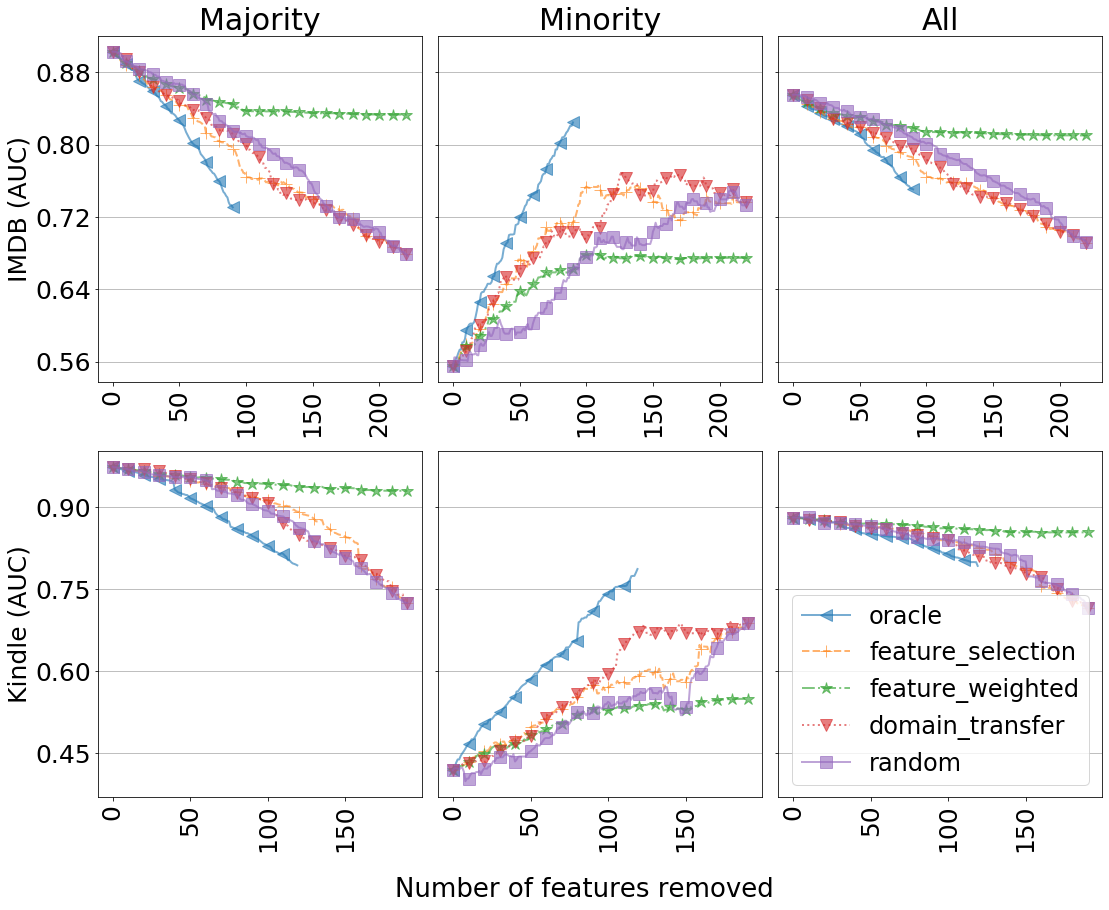

In [83]:
evaluate_feature_selection(task='sentiment',sample_by='priority')


 Toxic comment
Sample size for minority: 2
Sample size for majority: 7
Sampled 14860 train instances; 
test indices: (280 majority docs, 40 terms), (76 minority docs, 39 terms), intersection=0
Train distribution: Counter({-1: 7532, 1: 7328})
Test distribution: Counter({1: 280, -1: 76})
Majority distribution: Counter({1: 280})
Minority distribution: Counter({-1: 76})

 Toxic tweet
Sample size for minority: 2
Sample size for majority: 5
Sampled 6288 train instances; 
test indices: (360 majority docs, 72 terms), (126 minority docs, 68 terms), intersection=0
Train distribution: Counter({1: 3228, -1: 3060})
Test distribution: Counter({1: 360, -1: 126})
Majority distribution: Counter({1: 360})
Minority distribution: Counter({-1: 126})


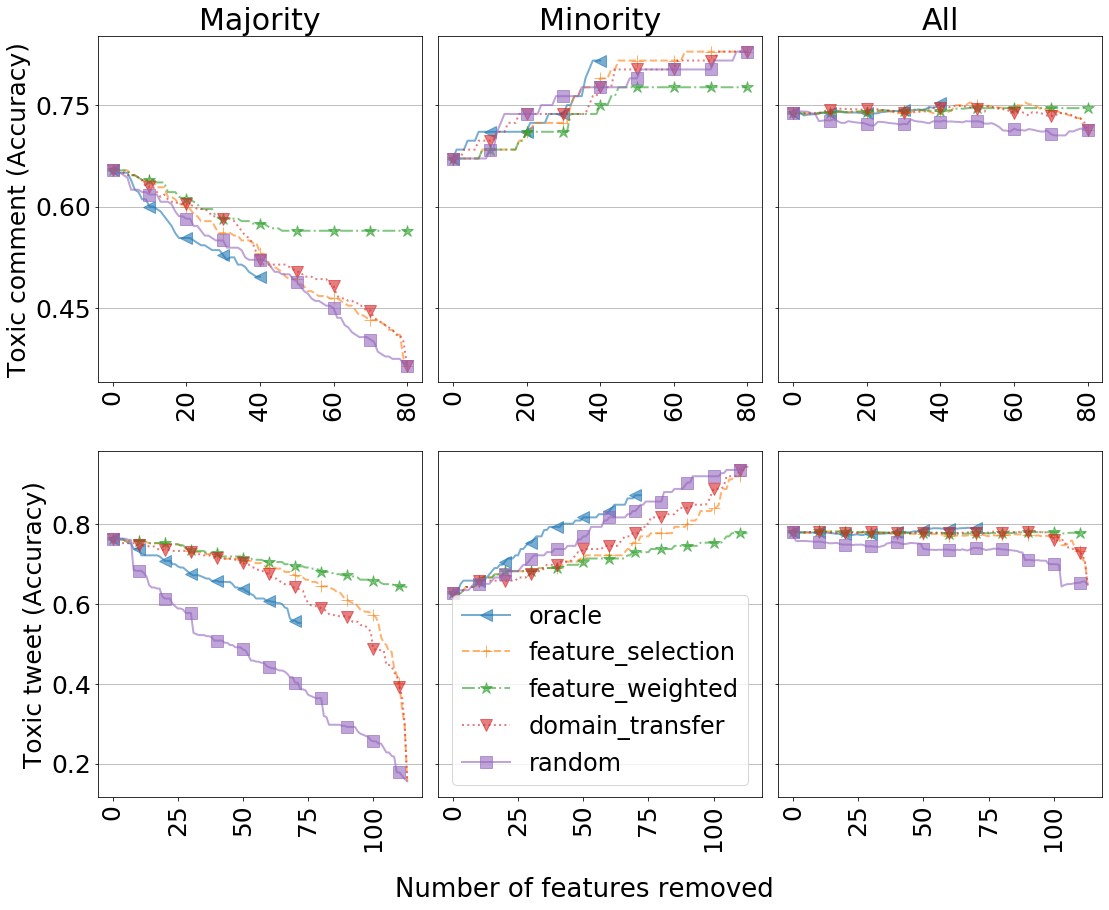

In [84]:
evaluate_feature_selection(task='toxic',sample_by='priority')

#### Sample_by == random: random split first, and then sample majority and minority groups



 IMDB
Sampled 6397 train instances; 
test indices: (179 majority docs, 90 terms), (86 minority docs, 58 terms), intersection=0
Train distribution: Counter({1: 3234, -1: 3163})
Test distribution: Counter({-1: 140, 1: 125})
Majority distribution: Counter({-1: 103, 1: 76})
Minority distribution: Counter({1: 49, -1: 37})

 Kindle
Sampled 12139 train instances; 
test indices: (229 majority docs, 119 terms), (136 minority docs, 93 terms), intersection=0
Train distribution: Counter({-1: 6135, 1: 6004})
Test distribution: Counter({1: 185, -1: 180})
Majority distribution: Counter({-1: 126, 1: 103})
Minority distribution: Counter({1: 82, -1: 54})


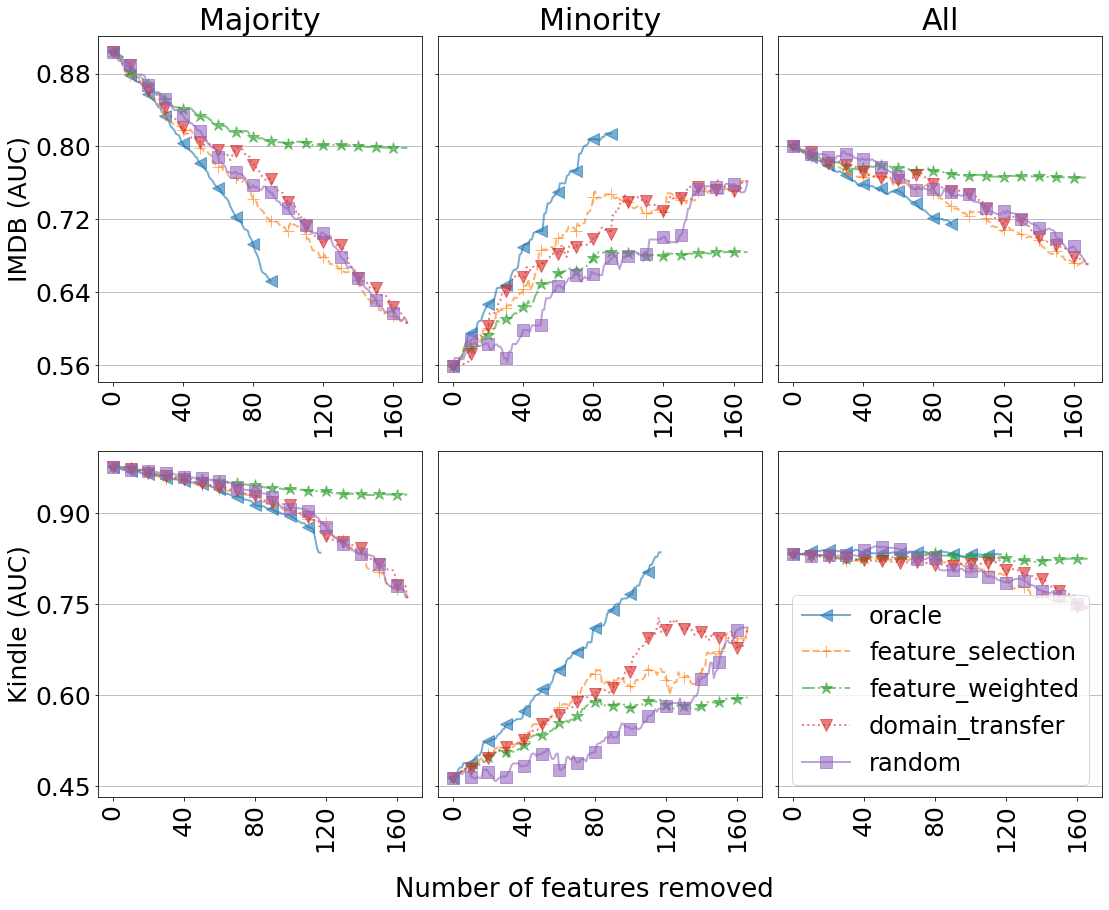

In [85]:
evaluate_feature_selection(task='sentiment',sample_by='random')


 Toxic comment
Sampled 9129 train instances; 
test indices: (78 majority docs, 40 terms), (51 minority docs, 30 terms), intersection=0
Train distribution: Counter({-1: 4569, 1: 4560})
Test distribution: Counter({1: 78, -1: 51})
Majority distribution: Counter({1: 78})
Minority distribution: Counter({-1: 51})

 Toxic tweet
Sampled 4064 train instances; 
test indices: (143 majority docs, 72 terms), (92 minority docs, 55 terms), intersection=0
Train distribution: Counter({1: 2131, -1: 1933})
Test distribution: Counter({1: 143, -1: 92})
Majority distribution: Counter({1: 143})
Minority distribution: Counter({-1: 92})


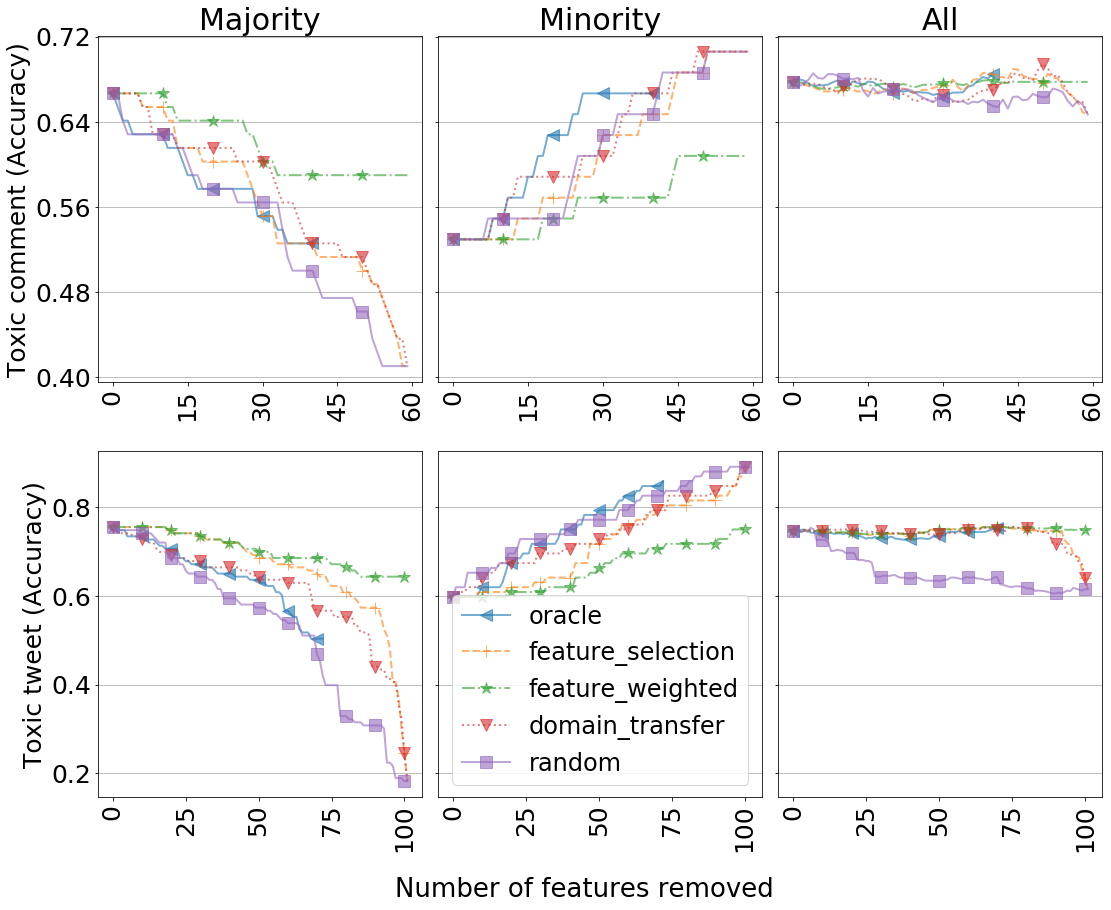

In [87]:
evaluate_feature_selection(task='toxic',sample_by='random')

### Supplemental experiment using sentiment lexicon for feature selection

In [80]:
def feature_selection_by_lexicon(ds_data, train_idx, test_idx, feature_order='lexicon',word_counts=None,verbose=False):
    """
    Using sentiment lexicon:
        - features in the lexicon are good terms;
        - features not in the lexicon are bad terms;
        - check classification result with only good terms;
    """
    sentiment_words = pd.read_csv('/data/zwang/2020_S/EMNLP/sentiment_lexicon/sentiment_lexicon.csv')
    
    clf = LogisticRegression(class_weight='auto', solver='lbfgs', max_iter=1000)
    clf.fit(ds_data.X[train_idx], ds_data.y[train_idx])
    
    terms_torem = list(set(ds_data.vec.get_feature_names()) - set(sentiment_words.word.values))
    term_idx = np.array([ds_data.vec.vocabulary_[t] for t in terms_torem])
    
    clf.coef_[0][term_idx] = 0
    print("Removed %d terms, %d remained" % (len(terms_torem), len(ds_data.vec.vocabulary_)-len(terms_torem)))
    
    pred_lb = clf.predict(ds_data.X[test_idx])
    pred_prob = clf.predict_proba(ds_data.X[test_idx])[:,1]
        
    if(len(Counter(ds_data.y[test_idx]).keys())==1): # data only contain one class (toxic_wiki, toxic_tw)
        score = accuracy_score(ds_data.y[test_idx], pred_lb)
    else:
        score = roc_auc_score(ds_data.y[test_idx], pred_prob)

    if verbose and len(terms_torem) > 0:
        print('removed (%s,%.3f) score=%.3f' % (terms_torem[-1][1], terms_torem[-1][0],score[-1]))
    
    return score, terms_torem

In [ ]:
path = '/data/zwang/2020_S/EMNLP/V_7_rerun/'
[ds_kindle, ds_imdb, ds_toxic_tw, ds_toxic] = pickle.load(open(path+'datasets_with_term_prob.pickle','rb'))

In [93]:
# result with sentiment lexicon
result_with_lexicon = []
for ds_data in [ds_imdb, ds_kindle, ds_toxic, ds_toxic_tw]:
    print('\n', ds_data.moniker)
    train_idx, majority_idx, minority_idx, maj_bad_terms, min_bad_terms = get_train_test_set(ds_data,smp_method='priority')
    test_idx = minority_idx + majority_idx
    word_counts = ds_data.X[test_idx].sum(axis=0).A1
    
    scores = {}
    for t_idx, t_col in zip([majority_idx, minority_idx, test_idx],['majority','minority','test']):
        val, rem_wds = feature_selection_by_lexicon(ds_data, train_idx, t_idx, feature_order='lexicon',word_counts=word_counts)
        scores[t_col] = float('%.3f' % val)
    result_with_lexicon.append(scores)
    

pd.DataFrame(result_with_lexicon).rename(index={0:'imdb',1:'kindle',2:'toxic_comment',3:'toxic_tweet'})


 imdb
Sample size for minority: 2
Sample size for majority: 7
Sampled 9895 train instances; 
test indices: (629 majority docs, 90 terms), (138 minority docs, 78 terms), intersection=0
4574
Removed 3239 terms, 1335 remained
Removed 3239 terms, 1335 remained
Removed 3239 terms, 1335 remained

 kindle
Sample size for minority: 2
Sample size for majority: 5
Sampled 19476 train instances; 
test indices: (583 majority docs, 119 terms), (174 minority docs, 113 terms), intersection=0
2384
Removed 1760 terms, 624 remained
Removed 1760 terms, 624 remained
Removed 1760 terms, 624 remained

 toxic
Sample size for minority: 2
Sample size for majority: 7
Sampled 14860 train instances; 
test indices: (280 majority docs, 40 terms), (76 minority docs, 39 terms), intersection=0
4628
Removed 3472 terms, 1156 remained
Removed 3472 terms, 1156 remained
Removed 3472 terms, 1156 remained

 toxic_tw
Sample size for minority: 2
Sample size for majority: 5
Sampled 6288 train instances; 
test indices: (360 majo

,majority,minority,test
imdb,0.730,0.776,0.740
kindle,0.823,0.636,0.779
toxic_comment,0.646,0.592,0.660
toxic_tweet,0.453,0.881,0.692


In [96]:
# result with feature selection
result_with_selection = []
for ds_data in [ds_imdb, ds_kindle, ds_toxic, ds_toxic_tw]:
    print('\n', ds_data.moniker)
    train_idx, majority_idx, minority_idx, maj_bad_terms, min_bad_terms = get_train_test_set(ds_data,smp_method='priority')
    test_idx = minority_idx + majority_idx
    word_counts = ds_data.X[test_idx].sum(axis=0).A1    
    
    scores = {}
    for t_idx, t_col in zip([majority_idx, minority_idx, test_idx],['majority','minority','test']):
        scores[t_col] = float('%.3f' % max(feature_selection(ds_data, train_idx, t_idx, feature_order='feature_selection')))
    result_with_selection.append(scores)
    
pd.DataFrame(result_with_selection).rename(index={0:'imdb',1:'kindle',2:'toxic_comment',3:'toxic_tweet'})


 imdb
Sample size for minority: 2
Sample size for majority: 7
Sampled 9895 train instances; 
test indices: (629 majority docs, 90 terms), (138 minority docs, 78 terms), intersection=0
4574

 kindle
Sample size for minority: 2
Sample size for majority: 5
Sampled 19476 train instances; 
test indices: (583 majority docs, 119 terms), (174 minority docs, 113 terms), intersection=0
2384

 toxic
Sample size for minority: 2
Sample size for majority: 7
Sampled 14860 train instances; 
test indices: (280 majority docs, 40 terms), (76 minority docs, 39 terms), intersection=0
4628

 toxic_tw
Sample size for minority: 2
Sample size for majority: 5
Sampled 6288 train instances; 
test indices: (360 majority docs, 72 terms), (126 minority docs, 68 terms), intersection=0
1866


,majority,minority,test
imdb,0.903,0.754,0.855
kindle,0.974,0.689,0.881
toxic_comment,0.654,0.829,0.754
toxic_tweet,0.764,0.944,0.783


- Example terms that are dataset-specific sentiment words

In [86]:
ds_data = ds_toxic
train_idx, majority_idx, minority_idx, maj_bad_terms, min_bad_terms = get_train_test_set(ds_data,smp_method='priority')
test_idx = minority_idx + majority_idx
word_counts = ds_data.X[test_idx].sum(axis=0).A1    
score, toxic_terms_torem = feature_selection_by_lexicon(ds_data, train_idx, t_idx, feature_order='lexicon')

Sample size for minority: 2
Sample size for majority: 7
Sampled 14860 train instances; 
test indices: (280 majority docs, 40 terms), (76 minority docs, 39 terms), intersection=0
Removed 3472 terms, 1156 remained


In [87]:
print(toxic_terms_torem[:100])

['robert', 'common', 'proudly', 'amongst', 'accepts', 'nations', 'ordered', 'been', 'british', 'politically', 'certain', 'association', 'org', 'secretary', 'wives', 'superiority', 'laden', 'alaskan', 'cpc', 'supremacist', 'typically', 'heritage', 'incest', 'embraced', 'ideology', 'russia', 'caucasian', 'lesson', 'genocidal', 'longer', 'anyone', 'diamond', 'clergies', 'accused', 'doug', 'indian', 'animals', 'cell', 'couple', 'customers', 'dogs', 'eventually', 'recruiting', 'regular', 'clown', 'found', 'suggestion', 'brings', 'homework', 'labels', 'investigation', 'applies', 'brag', 'tape', 'psycho', 'looting', 'now', 'bombed', 'base', 'strangers', 'listening', 'nut', 'proportion', 'therapy', 'blaming', 'congregation', 'whites', 'censorship', 'hundreds', 'anderson', 'his', 'stopping', 'york', 'photo', 'racially', 'read', 'allows', 'guise', 'mp', 'churches', 'performing', 'fuel', 'regulated', 'king', 'contributes', 'cost', 'fools', 'hiv', 'bans', 'quality', 'via', 'offices', 'began', 'den

In [88]:
ds_data = ds_kindle
train_idx, majority_idx, minority_idx, maj_bad_terms, min_bad_terms = get_train_test_set(ds_data,smp_method='priority')
test_idx = minority_idx + majority_idx
word_counts = ds_data.X[test_idx].sum(axis=0).A1    
score, sentiment_terms_torem = feature_selection_by_lexicon(ds_data, train_idx, t_idx, feature_order='lexicon')

Sample size for minority: 2
Sample size for majority: 5
Sampled 19476 train instances; 
test indices: (583 majority docs, 119 terms), (174 minority docs, 113 terms), intersection=0
Removed 1760 terms, 624 remained


In [90]:
print(sentiment_terms_torem[:100])

['underdeveloped', 'robert', 'common', 'ashley', 'adam', 'ordered', 'been', 'british', 'certain', 'holly', 'escape', 'jamie', 'edit', 'blake', 'lesson', 'longer', 'anyone', 'diamond', 'animals', 'couple', 'dogs', 'eventually', 'alex', 'found', 'brings', 'epilogue', 'now', 'listening', 'remotely', 'his', 'stopping', 'york', 'guessing', 'journal', 'read', 'allows', 'edited', 'typos', 'emotionally', 'king', 'cost', 'flow', 'random', 'quality', 'via', 'while', 'began', 'also', 'isn', 'mention', 'downloaded', 'where', 'pack', 'style', 'needed', 'quirky', 'behind', 'intrigued', 'sentence', 'rooting', 'zane', 'let', 'takes', '70', 'latest', 'alright', 'desserts', 'feeling', 'reasons', 'website', 'emotion', 'price', 'seat', '1st', 'connor', 'edition', 'rhyme', 'glued', 'city', 'til', 'creating', 'water', 'into', 'captures', 'spelling', 'there', 'angels', 'chemistry', 'halloween', 'completed', 'writers', 'lot', 'magazine', 'lust', 'olivia', 'student', 'next', 'bond', 'bubbles', 'high']


(117, 24)